In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Loading the dataset

In [ ]:
# Load the dataset as (image,label) tuples and split in 80% train and 20% test data
train_dataset_unprocessed, test_dataset_unprocessed = tfds.load("Malaria",as_supervised=True,split=['train[:80%]','train[-20%:]'])

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteACBLBU/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


# Inspecting the dataset

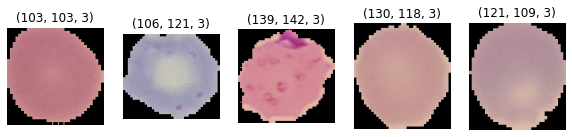

In [ ]:
fig, ax = plt.subplots(1,5,figsize=(10,15))
for i, (x,y) in enumerate(train_dataset_unprocessed):
    if i>4:
        break    
    ax[i].imshow(x)
    ax[i].set_title(x.shape)
    ax[i].axis("off")

The images in our dataset have different shapes. We need them to have all the same shape to feed them to our CNN. The best solution for this is to use tf.image.resize_with_pad which adds zeros around the images so they all have the same size. This kind of padding doesn't really change our data, because the images already have a black background.

# Preprocessing the data

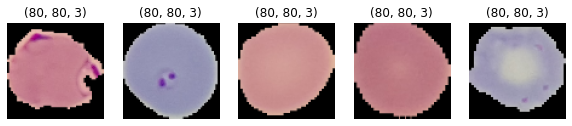

In [ ]:
# Setting the input shape
my_input_shape = (80,80,3)

train_dataset = train_dataset_unprocessed
test_dataset = test_dataset_unprocessed

train_dataset = train_dataset.shuffle(64)

# Mapping the data set to get images of the same shape and one-hot labels in parallel to improve performance
# Cache the mapped data to avoid mapping for every epoch
train_dataset=train_dataset.map(
    lambda image,label: (
        tf.image.resize_with_pad(image/255,my_input_shape[0],my_input_shape[1]),tf.one_hot(label,1)),
        num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

# Inspect the mapped images before batching
fig, ax = plt.subplots(1,5,figsize=(10,15))
for i, (x,y) in enumerate(train_dataset):
    if i>4:
        break
    ax[i].imshow(x)
    ax[i].set_title(x.shape)
    ax[i].axis("off")

# Create batches
train_dataset = train_dataset.batch(64)
# Prefetch the dataset to improve performance
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Do the same for the test data
test_dataset = test_dataset.shuffle(64)

test_dataset=test_dataset.map(
    lambda image,label: (
        tf.image.resize_with_pad(image/255,my_input_shape[0],my_input_shape[1]),tf.one_hot(label,1)),
        num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Define the model

In [ ]:
from tensorflow.keras import Model

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.convolutional_layer_1 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=5,
            strides=3,
            padding='same',
            activation='relu',
            input_shape=my_input_shape)
        
        self.max_pool_1 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_2 = tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=3,
            padding='same',
            activation='relu')
        
        self.max_pool_2 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_3 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=3,
            padding='same',
            activation='relu')
        
        self.max_pool_3 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_4 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=3,
            padding='same',
            activation='relu',
            input_shape=my_input_shape)
        
        self.max_pool_4 = tf.keras.layers.MaxPool2D()
        
        self.global_average_pooling_layer = tf.keras.layers.GlobalAvgPool2D()

        self.output_layer = tf.keras.layers.Dense(
            units=1,
            activation='sigmoid')

    def call(self, x):
        x = self.convolutional_layer_1(x)
        x = self.max_pool_1(x)
        x = self.convolutional_layer_2(x)
        x = self.max_pool_2(x)
        x = self.convolutional_layer_3(x)
        x = self.max_pool_3(x)
        x = self.convolutional_layer_4(x)
        x = self.max_pool_4(x)
        x = self.global_average_pooling_layer(x)
        x = self.output_layer(x)
        return x

# Defining the training and test 

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.greater(prediction,0.5), tf.equal(target,1.0)), 'float'))
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.greater(prediction,0.5), tf.equal(target,1.0)), 'float'))
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# Training the model

In [ ]:
%%time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.00008
running_average_factor = 0.95

model = Model()

# Initialize the loss
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing model performance on train and test data before learning
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=64)
    test_dataset = test_dataset.shuffle(buffer_size=64)

    # Training
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
        
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)

    # Testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    print('Train loss: ',running_average_loss)
    print('Test loss: ',test_loss)
    print('Train accuracy: ',running_average_accuracy)
    print('Test accuracy: ',test_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Train loss:  tf.Tensor(0.5639318, shape=(), dtype=float32)
Test loss:  0.56221735
Train accuracy:  tf.Tensor(0.71256745, shape=(), dtype=float32)
Test accuracy:  0.7262931
Epoch: __ 1
Train loss:  tf.Tensor(0.34009394, shape=(), dtype=float32)
Test loss:  0.31291857
Train accuracy:  tf.Tensor(0.85601395, shape=(), dtype=float32)
Test accuracy:  0.87015086
Epoch: __ 2
Train loss:  tf.Tensor(0.20291479, shape=(), dtype=float32)
Test loss:  0.19574967
Train accuracy:  tf.Tensor(0.9278428, shape=(), dtype=float32)
Test accuracy:  0.9351652
Epoch: __ 3
Train loss:  tf.Tensor(0.1712361, shape=(), dtype=float32)
Test loss:  0.1847283
Train accuracy:  tf.Tensor(0.9447717, shape=(), dtype=float32)
Test accuracy:  0.93696123
Epoch: __ 4
Train loss:  tf.Tensor(0.15384077, shape=(), dtype=float32)
Test loss:  0.16880688
Train accuracy:  tf.Tensor(0.95075375, shape=(), dtype=float32)
Test accuracy:  0.9445043
Epoch: __ 5
Train loss:  tf.Tensor(0.14844747, shape=(), dtype=float32)
Test l

# Plotting accuracy and loss for training and test data.

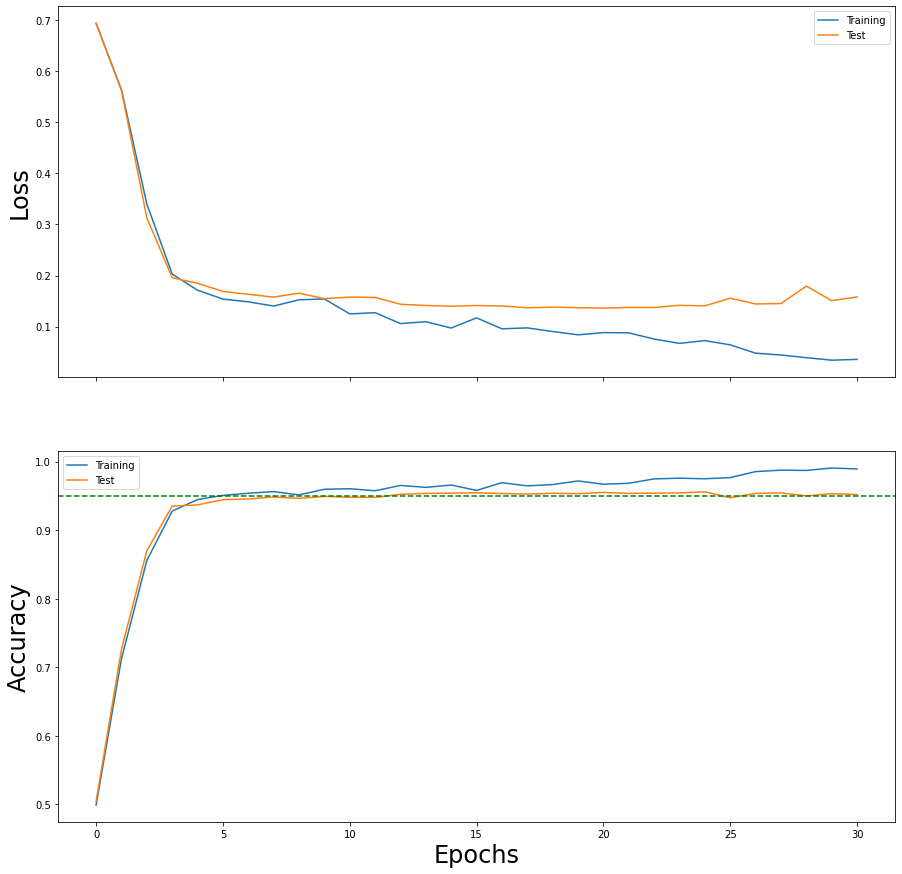

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,15))
ax[0].plot(train_losses,label="Training")
ax[0].plot(test_losses,label="Test")

ax[1].plot(train_accuracies,label="Training")
ax[1].plot(test_accuracies,label="Test")

fontsize=24
ax[0].set_ylabel("Loss",fontsize=fontsize)
ax[1].set_ylabel("Accuracy",fontsize=fontsize)
ax[1].set_xlabel("Epochs",fontsize=fontsize)
ax[1].axhline(0.95,xmax=num_epochs,c='g',ls='--')
ax[0].legend()
ax[1].legend()
plt.show()